In [1]:
import re
import urllib.request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import datetime

# page nos. 1 to 1539
persian_steingass_url = 'https://dsal.uchicago.edu/cgi-bin/app/steingass_query.py?page={}'

In [23]:
def processDefChild(child):
    if child.name:
        return '<{0}>{1}</{0}>'.format(child.name, child.text.strip())
    else:
        return child.text.strip()
    
def unmatchedParen(s):
    if s is None:
        return ''
    stack = []
    for c in s:
        if c == '(':
            stack.append(c)
        elif c == ')':
            if len(stack) == 0:
                return ')'
            stack.pop()
    if len(stack) > 0:
        return '('
    else:
        return ''


def processEntry(hw):
    result = {
        'definition': ' '.join(processDefChild(sib)
                for sib in hw.next_siblings),
        'pa': hw.pa.string,
        'ro': hw.i.string if hw.i else None,
        'lang': hw.parent.lang.string if hw.parent.lang else None,
        'page': page,
        # the following are only used for intermediate processing
        'hw_raw': hw.text
    }
    
    # assumes that missing parens exist in adjacent elements!!
    if unmatchedParen(result['ro']) == '(':
        result['ro'] = result['ro'][:result['ro'].index('(')].strip()
        
        result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):] + 
                            result['definition'][:result['definition'].index(')') + 1]).strip()
        
        result['definition'] = result['definition'][result['definition'].index(')') + 1:].strip()
    elif unmatchedParen(result['ro']) == ')':
        result['ro'] = result['ro'][result['ro'].index(')') + 1:].strip()
        result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):]).strip()
    
    result['definition'] = re.sub(r'^\s*,', '', result['definition']).strip()
    
    del result['hw_raw']
    
    return result

def getSteingassPage(page):
    with urllib.request.urlopen(persian_steingass_url.format(page)) as response:
        html = response.read()
        html = html.decode('utf-8')
    bs = BeautifulSoup(html)
    df = DataFrame([processEntry(hw) for hw in bs.find_all('hw')])
    if len(df) == 0:
        return df
    else:
        return df[['pa', 'ro', 'definition', 'lang', 'page']]

In [27]:
DON'T RERUN

pages = []

for page in range(1, 1540):
    print('=', end='')
    if page % 5 == 0:
        print('|', end='')
        if page % 50 == 0:
            print(page, datetime.datetime.now())
    pages.append(getSteingassPage(page))

FullDict = pd.concat(pages)

FullDict.to_csv('steingass.csv')

SyntaxError: EOL while scanning string literal (3644633377.py, line 1)

In [24]:
FullDict.to_csv('steingass.csv')

In [25]:
FullDict = pd.read_csv('steingass.csv')
SUBDEF_CHAR = '—'

FullDict['def_len'] = FullDict.definition.str.len()
FullDict['subdef_count'] = FullDict.definition.fillna('').apply(lambda d: len(d.split(SUBDEF_CHAR)))

<AxesSubplot:>

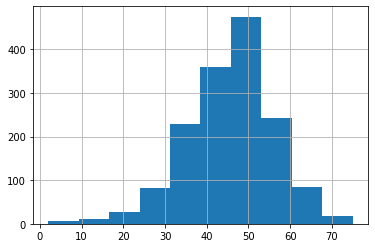

In [26]:
#Entries per page
FullDict.page.value_counts().hist()

In [15]:
# missing pages are all due to continuations of long entries, grouped withfollowing pages
# 2
# 41
# 486
# 520
# 665
# 666
for p in range(1, 1540):
    if not p in list(FullDict.page):
        print(p)

2
41
486
520
665
666


In [16]:
# Length of definitions varies a lot

FullDict.definition.str.len().describe()

count    69888.000000
mean        84.005995
std        206.622767
min          0.000000
25%         22.000000
50%         41.000000
75%         86.000000
max      19426.000000
Name: definition, dtype: float64

In [17]:
# top words by definition length

'; '.join(list(FullDict.sort_values('def_len', ascending=False)[:150].ro))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; az; sang; ḵẖat̤t̤; ahl; gil; kār; yāʼ, yā; chashm; ʻalm; dandān; ḥarf; ṣāḥib; g̠ẖair; rāh; ātish; ḵẖūd; īn; ḵẖūn; rawī; marg̠ẖ; dil; zabān, zubān; gosh; faʻl; ḥaqq, ḥaq; nān; kashīdan; tīr; bād; zar; parda; rang; ʻalá; h; roz; dāman; suḵẖun, suḵẖan, saḵẖan, saḵẖun; dam; ḵẖāna; pusht; gard; jāma; kulāh; teg̠ẖ; dar; ḵẖāk; daryā; ʻain; bāz; pāy; angusht; ʻarẓ; jān; ḵẖẉāb; sher; qalb; naqsh; giriftan; taḵẖt; nafs; ʻanān; shāḵẖ; lab; shab; dāg̠ẖ; pas; taḵẖta; zīr, zer; qat̤ʻ; y; band; chashma; ʻālam; kāsa; dār; qadm; ḵẖam; chūb, chob; gara; pesh; kamar; āyina; husn; rishta; jamʻ; ism; chirāg̠ẖ; kāmān; māh; jām; tuḵẖm; naql; naz̤r; ganj; charḵẖ; diraḵẖt; panja; pīr; mail; t̤arf; nāma; ʻarq; bār; ḵẖār; qabl; kāg̠ẖaẕ, kāg̠ẖiẕ; ḥurūf; māl; sharāb; naʻl; dard; nāḵẖun; dīda; qaẓā; nām; shamsher; kashtī; ḥukm; kala; zamīn; bar sar; kardan; w; cha; raish; m; man; ban; raug̠ẖan; gāu, gāo, gāv; baḥr; qūwat, quwwat; qafl; par, parr; ḥalqat, ḥalqa; abū; nishān; ashk; war

In [18]:
# top words by subdefinition count
# the one with missing romanization is mīr

'; '.join(list(FullDict.sort_values('subdef_count', ascending=False)[:150].ro.fillna('!!!')))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; ahl; az; sang; gil; ḵẖat̤t̤; ʻalm; ṣāḥib; g̠ẖair; ḥarf; rāh; kār; dandān; chashm; ḵẖūd; ātish; īn; ḵẖūn; rawī; dil; marg̠ẖ; zar; zabān, zubān; kashīdan; nān; ʻalá; ḥaqq, ḥaq; bād; parda; gosh; ḵẖāna; suḵẖun, suḵẖan, saḵẖan, saḵẖun; faʻl; roz; dam; rang; dāman; sher; pusht; daryā; dār; tīr; ḵẖẉāb; ḵẖāk; pas; ism; diraḵẖt; jāma; pāy; teg̠ẖ; shab; giriftan; gard; zīr, zer; lab; angusht; ʻālam; jān; ʻanān; kāsa; chūb, chob; husn; dar; taḵẖta; ḥurūf; chashma; pesh; dard; naqsh; kāmān; kulāh; raug̠ẖan; tuḵẖm; māh; chirāg̠ẖ; qadm; shāḵẖ; kardan; bāz; qūwat, quwwat; gara; māl; bilā (bi-lā); dīda; qat̤ʻ; āyina; taḵẖt; sharāb; nafs; kashtī; shamʻ; pīr; zamīn; abū; ḵẖār; rishta; dāg̠ẖ; jauhar; baḥr; waqt; cha; zadan; har; jām; ḵẖam; āstīn; jāy; arbāb; !!!; bāg̠ẖ; ḥamá; ʻain; nām; jamʻ; ʻarq; ganj; gāu, gāo, gāv; ḥukm; ʻuẓlat; panja; ḥalqat, ḥalqa; kamar; rag; nāḵẖun; ashk; bar sar; ʻand, ʻind, ʻund; qalm; chādar; ban; charḵẖ; mā; koh, kūh; nihādan; man; ẕī; tā; bur

In [19]:
subdefs = []

for _, row in FullDict[FullDict['subdef_count'] > 1].iterrows():
    for subdef in row.definition.split(SUBDEF_CHAR)[1:]:
        subdefs.append({
            'hw_ro': row['ro'],
            'subdef': subdef,
            'page': row['page'],
            'subdef_len': len(subdef)
        })

#DataFrame(subdefs).sample(50)

DataFrame(subdefs).sort_values('subdef_len', ascending=False)[:50]

,hw_ro,subdef,page,subdef_len
31538,"yāʼ, yā",i. <i>yāʼi (yāyi) istimrārī</i> (being <i>maj...,1524,5473
15428,sī laḥn,1. <i>ārāyishi ḵẖẉurshed (jahān)</i> ; 2. <i>...,717,953
29527,naz̤r,"<i>naz̤ar</i> (v.n.), Looking at, beholding, ...",1410,833
26729,maṣlīy,"<i>muṣallá</i> , Prayed; merciful, propitious...",1254,757
31280,"halāl, hilāl","<i>hilāl</i> (v.n. 3 of <pa>هلّ</pa> ), Agree...",1505,671
24722,m,am</i> (after a noun terminating in a vowel f...,1136,631
18172,ʻarf,"<i>ʻurf</i> , Being known, public, notorious;...",844,611
23027,kanda,"<i>kunda</i> , The stocks for offenders, a ki...",1054,610
21473,qamʻ,"<i>qamaʻ</i> (v.n.), Suffering from a fistula...",989,524
28696,mail,"<i>mīl</i> , A mile of four thousand cubits o...",1363,522


In [20]:
FullDict[FullDict.ro.isnull()].sort_values('def_len', ascending=False)

,pa,ro,definition,lang,page,def_len,subdef_count
23,مير,None,"(for A. <pa>امير</pa> ), An emperor, prince, l...",a,1360,1414,23
8,ع ʻ,None,called <i>ʻaini g̠ẖair manqūt̤a</i> or <i>ʻain...,None,828,824,1
46,ص,None,The seventeenth letter of the Arabic-Persian a...,None,777,635,1
54,س,None,"called <i>sīni g̠ẖair manqūt̤a, sīni muhmala</...",None,637,307,1
21,همز,None,"(v.n.), Squeezing (in the hand); making a sign...",A,1510,283,2
14,تععيل,None,"Causing to be unemployed; rendering vacant, vo...",A,309,253,2
26,اختلال,None,"Being lean, emaciated; standing in need; sewin...",A,24,232,3
19,انشاز,None,Raising (anything) from its place; collecting ...,A,111,154,1
6,گاو نبطونك,None,"(?), (in the dialect of Shīrāz) A kind of spur...",None,1074,137,1
27,ناشبسته,None,"(?), Unwashed (the word given by Meninsky is e...",None,1373,101,1


In [44]:
FullDict[FullDict.definition.isnull()]

,Unnamed: 0,pa,ro,definition,lang,page,def_len,subdef_count
478,8,آتش آلود,ātish-ālūd,NaN,NaN,13,NaN,1


In [93]:
for _, row in FullDict[FullDict.definition.fillna('').apply(unmatchedParen).apply(bool)].iterrows():
    print('==={}, page {}==='.format(row.ro, row.page))
    print(row.definition)

===aḥsant (aḥsanta, page 21===
thou hast done well), Well done! bravo!
===iḵẖtifāʼ, page 24===
Hiding, covering, concealment).
===āḵẖsuma, āḵẖsama, aḵẖsuma, aḵẖsamah, page 25===
), A liquor made from barley, rice, or millet.
===azrār, page 44===
(pl. of <i>zirr</i> ), Buttons; — <i>izrār</i> (v.n. 4 of <pa>زرّ</pa> ), Putting buttons to a garment).
===āsh, page 62===
(S. <i>āśa</i> ), Meat, victuals, viands, soup, broth, gruel, pottage; drinking, a drinker; — <i>āshi bādardī</i> , A dish called after Bādard, a place in Khurasān; — <i>āshi bachagān</i> , Castor (a medicine given to infants); — <i>āsh puḵẖtan</i> , To stir up one against another; — <i>āshi tatmāj</i> , A kind of vermicelli dish; — <i>āshi tazwīr (parhez)</i> , Gruel for the sick; — <i>āshi taʻziya</i> , A dish distributed to the neighbours and poor on a day of mourning (as on that for the death of Husain); — <i>āshi tū dar kāsaʼi tūst</i> , Your food is in your bowl, <i>i.e.</i> your living or lot is provided for; — <i>ā

In [95]:
FullDict[FullDict.ro.fillna('').apply(unmatchedParen).apply(bool)]

,Unnamed: 0,pa,ro,definition,lang,page,def_len,subdef_count
877,29,احسنت,aḥsant (aḥsanta,"thou hast done well), Well done! bravo!",A,21,39.0,1
9213,2,بسا,basā (bas,"with the <pa>ا</pa> of the vocative), Many, so...",NaN,185,225.0,2
10160,22,بنطش,baḥri) bunt̤ush,(Sea of) Pontus.,A G,203,16.0,1
11146,50,بيستون,bīstūn (bī-sutūn,"Without pillars), Name of a mountain in Persia...",NaN,220,60.0,1
11277,13,بى فرهنگ,farangi) bī-farhang,The imprudent Franks (or Christians in general).,NaN,223,48.0,1
12755,67,پژوده,ḵẖabar-) pazhūda,A spy.,NaN,248,6.0,1
13712,28,پیشگو,pesh-go (gū,One who presents petitions; one who introduces...,NaN,267,105.0,1
21315,34,حنيفة,abū) ḥanīfat (ḥanīfa),Name of twenty learned doctors; the most celeb...,A,432,148.0,1
21923,10,خباث,yā) ḵẖabās̤i,O infamous (woman)!,A,446,19.0,1
26563,39,دهمان,s̤inyu) duhmān,Evening prayers.,NaN,549,16.0,1


In [96]:
FullDict[FullDict.definition.fillna('').apply(unmatchedParen).apply(bool)]

,Unnamed: 0,pa,ro,definition,lang,page,def_len,subdef_count
877,29,احسنت,aḥsant (aḥsanta,"thou hast done well), Well done! bravo!",A,21,39.0,1
999,18,اختفاء,iḵẖtifāʼ,"Hiding, covering, concealment).",A,24,31.0,1
1057,30,اخسمه,"āḵẖsuma, āḵẖsama, aḵẖsuma, aḵẖsamah","), A liquor made from barley, rice, or millet.",NaN,25,46.0,1
1977,0,ازرار,azrār,"(pl. of <i>zirr</i> ), Buttons; — <i>izrār</i>...",A,44,104.0,2
2913,12,آش,āsh,"(S. <i>āśa</i> ), Meat, victuals, viands, soup...",NaN,62,1328.0,19
...,...,...,...,...,...,...,...,...
64626,43,نگين,nigīn,"A ring, especially the seal-ring of a prince; ...",NaN,1424,422.0,6
66814,31,وعدة,"waʻdat, waʻda","A promise, vow; any determined, appointed, cer...",A,1473,506.0,4
66856,36,وغف,wag̠ẖf,"(v.n.), Walking fast, running; weakness in the...",A,1474,151.0,1
67206,50,ويشه,wesha,"A forest, wood (cf. <pa>بيشه</pa> p. 221; — <i...",NaN,1483,63.0,2


In [71]:
FullDict.ro.value_counts()

dakan             3
āb                3
rāmī              3
anīs              3
bar               3
                 ..
ḵẖunukā           1
ḵẖunkār           1
ḵẖunuk-jān        1
ḵẖunuk-kunanda    1
yayan             1
Name: ro, Length: 69276, dtype: int64

In [232]:
FullDict.fillna('_').lang.value_counts() #.plot.pie()

_        35328
A        25321
a         8141
T          386
G          258
H          150
t          111
SY          38
M           28
a t         26
h           14
L           10
g a          9
S            9
E            9
R            8
t a          6
g            6
ā            5
P            5
a h          3
m            3
A P          2
B            1
SP           1
o            1
a p t        1
SY.          1
HE           1
H.           1
PORT.        1
A G          1
U            1
A T          1
r            1
Name: lang, dtype: int64

In [6]:
getSteingassPage(267)

ValueError: substring not found

In [10]:
with urllib.request.urlopen(persian_steingass_url.format(21)) as response:
    html = response.read()
    html = html.decode('utf-8')
    bs = BeautifulSoup(html)

In [11]:
def processEntry(hw):
    result = {
        'definition': ' '.join(processDefChild(sib)
                for sib in hw.next_siblings),
        'pa': hw.pa.string,
        'ro': hw.i.string if hw.i else None,
        'lang': hw.parent.lang.string if hw.parent.lang else None,
        'page': page,
        # the following are only used for intermediate processing
        'hw_raw': hw.text
    }
    
    if unmatchedParen(result['ro']) == '(':
        result['ro'] = result['ro'][:result['ro'].index('(')].strip()

        if ')' in result['hw_raw']:
            result['comment'] = result['hw_raw'][result['hw_raw'].index('('):
                                                 result['hw_raw'].index(')') + 1]
        elif ')' in result['definition']:
            result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):] + 
                                result['definition'][:result['definition'].index(')') + 1]).strip()
            result['definition'] = result['definition'][result['definition'].index(')') + 1:].strip()
    elif unmatchedParen(result['ro']) == ')':
        result['ro'] = result['ro'][result['ro'].index(')') + 1:].strip()
        result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):]).strip()
    
    result['definition'] = re.sub(r'^\s*,', '', result['definition']).strip()
    
    del result['hw_raw']
    
    return result

(lambda x: [i for i in x if 'comment' in i])([processEntry(hw) for hw in bs.find_all('hw')])

[{'definition': 'Well done! bravo!',
  'pa': 'احسنت',
  'ro': 'aḥsant',
  'lang': 'A',
  'page': 267,
  'comment': '(aḥsanta, thou hast done well)'}]